In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mysql.connector

db = mysql.connector.connect(host = "input your host",
                             username = "type your username",
                             password = "***********",
                             database = "ecommerce")

cur = db.cursor()

# 1. List all unique cities where customers are located.

In [49]:
query = """select distinct customer_city from customers"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=['customer_city'])
print(df.head())

           customer_city
0                 franca
1  sao bernardo do campo
2              sao paulo
3        mogi das cruzes
4               campinas


# 2. Count the number of orders placed in 2017.

In [19]:
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()
print("total orders placed in 2017:", data[0][0])

total orders placed in 2017: 45101


# 3. Find the total sales per category.

In [20]:
query = """select products.product_category category, 
round(sum(payments.payment_value), 2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
print(df)

                        Category       Sales
0                      perfumery   506738.66
1           Furniture Decoration  1430176.39
2                      telephony   486882.05
3   Fashion Bags and Accessories   218158.28
4                 bed table bath  1712553.67
..                           ...         ...
69                cds music dvds     1199.43
70                    La Cuisine     2913.53
71   Fashion Children's Clothing      785.67
72                      PC Gamer     2174.43
73        insurance and services      324.51

[74 rows x 2 columns]


# 4. Calculate the percentage of orders that were paid in installments.

In [21]:
query = """select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*) * 100 from payments
"""

cur.execute(query)

data = cur.fetchall()
print("the percentage of orders that were paid in installments is", data[0][0])

the percentage of orders that were paid in installments is 99.9981


# 5. Count the number of customers from each state. 

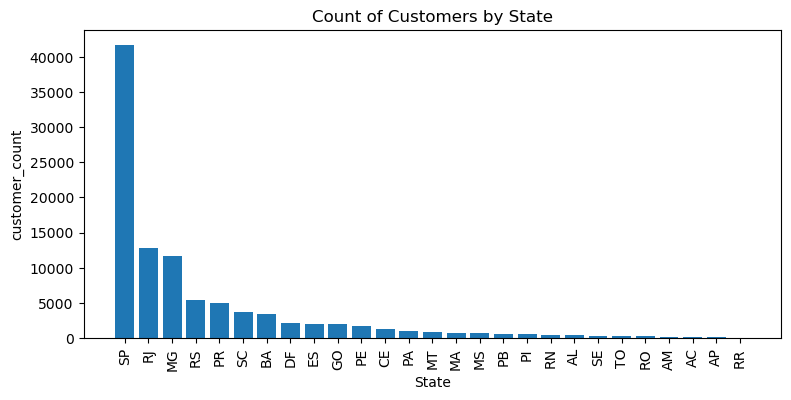

In [23]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (9, 4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("customer_count")
plt.title("Count of Customers by State")
plt.show()

# 6. Calculate the number of orders per month in 2018.

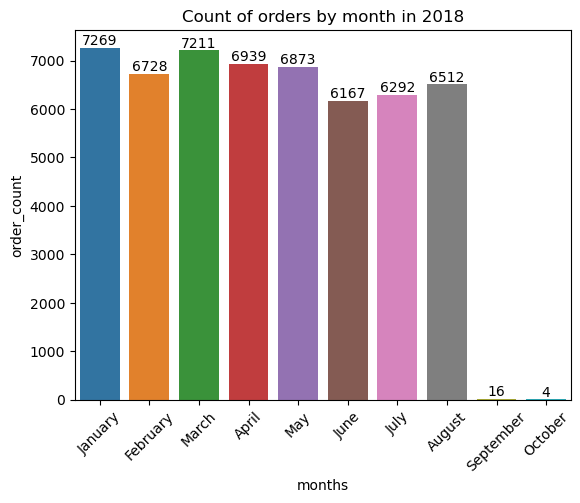

In [24]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [25]:
query = """with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as OC
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc), 2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,  columns = ["Customer City", "average orders"])
print(df.head(10))

        Customer City average orders
0      padre carvalho           7.00
1         celso ramos           6.50
2       candido godoi           6.00
3               datas           6.00
4      matias olimpio           5.00
5  morro de sao paulo           4.00
6          cidelandia           4.00
7             picarra           4.00
8     teixeira soares           4.00
9          curralinho           4.00


# 8. Calculate the percentage of total revenue contributed by each product category.

In [27]:
query = """ SELECT 
    UPPER(products.product_category) AS category, 
    ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100, 2) AS sales_percentage
FROM 
    products 
JOIN 
    order_items ON products.product_id = order_items.product_id
JOIN 
    payments ON payments.order_id = order_items.order_id
GROUP BY 
    category 
ORDER BY 
    sales_percentage DESC

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage Distribution"])
print(df)  

                       Category  Percentage Distribution
0                BED TABLE BATH                    10.70
1                 HEALTH BEAUTY                    10.35
2          COMPUTER ACCESSORIES                     9.90
3          FURNITURE DECORATION                     8.93
4               WATCHES PRESENT                     8.93
..                          ...                      ...
69              HOUSE COMFORT 2                     0.01
70               CDS MUSIC DVDS                     0.01
71                     PC GAMER                     0.01
72  FASHION CHILDREN'S CLOTHING                     0.00
73       INSURANCE AND SERVICES                     0.00

[74 rows x 2 columns]


# 9. Identify the correlation between product price and the number of times a product has been purchased.

The correlation between price and number of times a product has been purchased is:  -0.10631514167157562


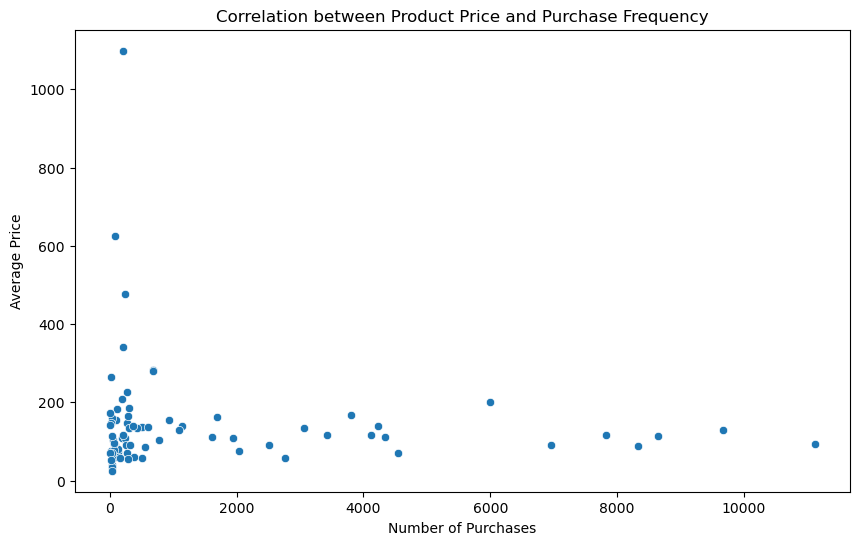

In [31]:
query = """ select products.product_category,
count(order_items.product_id),
round(avg(order_items.price), 2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category

"""

cur.execute(query)
data = cur.fetchall()

# Create a dataframe
df = pd.DataFrame(data, columns = ["Category", "Order_Count", "Price"])

# Calculate correlation
arr1 = df["Order_Count"]
arr2 = df["Price"]
a = np.corrcoef(arr1, arr2)

print("The correlation between price and number of times a product has been purchased is: ", a[0][-1])

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Order_Count", y="Price", data=df)
plt.title("Correlation between Product Price and Purchase Frequency")
plt.xlabel("Number of Purchases")
plt.ylabel("Average Price")
plt.show()

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

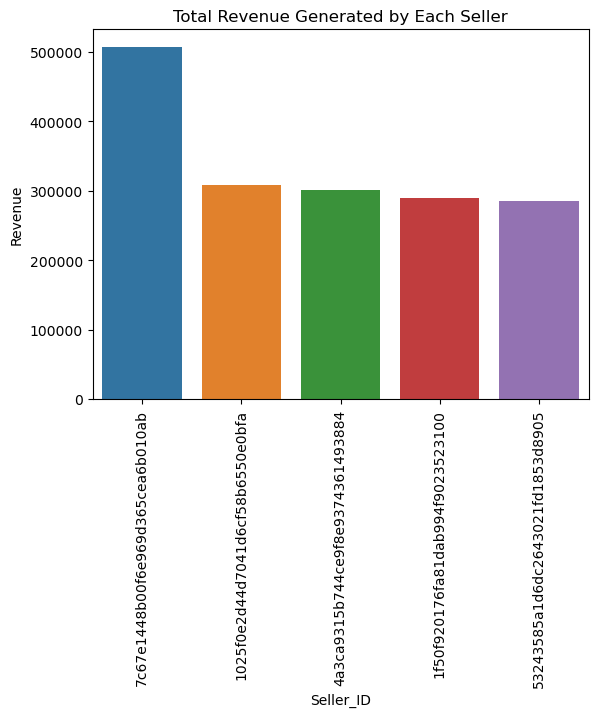

In [37]:
query = """ select *, dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) 
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a

"""

# Execute the query
cur.execute(query)

# Fetch all results
data = cur.fetchall()

# Load the data into a DataFrame for better readability and analysis
df = pd.DataFrame(data, columns=["Seller_ID", "Revenue", "Rank"])
df = df.head()
sns.barplot(x="Seller_ID", y="Revenue", data=df)
plt.title("Total Revenue Generated by Each Seller")
plt.xticks(rotation=90)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

                             customer_id order_purchase_timestamp  payment  \
0       00012a2ce6f8dcda20d059ce98491703      2017-11-14 16:08:26   114.74   
1       000161a058600d5901f007fab4c27140      2017-07-16 09:40:32    67.41   
2       0001fd6190edaaf884bcaf3d49edf079      2017-02-28 11:06:43   195.42   
3       0002414f95344307404f0ace7a26f1d5      2017-08-16 13:09:20   179.35   
4       000379cdec625522490c315e70c7a9fb      2018-04-02 13:42:17   107.01   
...                                  ...                      ...      ...   
103881  fffecc9f79fd8c764f843e9951b11341      2018-03-29 16:59:26    71.23   
103882  fffeda5b6d849fbd39689bb92087f431      2018-05-22 13:36:02    63.13   
103883  ffff42319e9b2d713724ae527742af25      2018-06-13 16:57:05   214.13   
103884  ffffa3172527f765de70084a7e53aae8      2017-09-02 11:53:32    45.50   
103885  ffffe8b65bbe3087b653a978c870db99      2017-09-29 14:07:03    18.37   

        moving_avg  
0       114.739998  
1        67.410004  


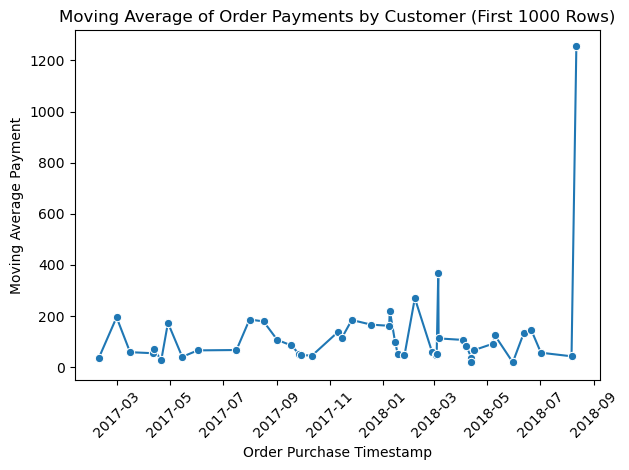

In [40]:
query = """
SELECT customer_id, order_purchase_timestamp, payment,
       AVG(payment) OVER (PARTITION BY customer_id ORDER BY order_purchase_timestamp
                          ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_avg
FROM (
    SELECT orders.customer_id, orders.order_purchase_timestamp,
           payments.payment_value AS payment
    FROM payments
    JOIN orders ON payments.order_id = orders.order_id
) AS a;
"""


cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id", "order_purchase_timestamp", "payment", "moving_avg"])
print(df)

# Ensure datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp']) 

# Limit to first 50 rows for visualization
df_visual = df.head(50)

# Plotting
sns.lineplot(data=df_visual, x="order_purchase_timestamp", y="moving_avg", marker="o")
plt.title("Moving Average of Order Payments by Customer (First 1000 Rows)")
plt.xlabel("Order Purchase Timestamp")
plt.ylabel("Moving Average Payment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 12. Calculate the cumulative sales per month for each year.

    Year  Month     Payment  Cumulative Sales
0   2016      9      252.24            252.24
1   2016     10    59090.48          59342.72
2   2016     12       19.62          59362.34
3   2017      1   138488.04         197850.38
4   2017      2   291908.01         489758.39
5   2017      3   449863.60         939621.99
6   2017      4   417788.03        1357410.02
7   2017      5   592918.82        1950328.84
8   2017      6   511276.38        2461605.22
9   2017      7   592382.92        3053988.14
10  2017      8   674396.32        3728384.46
11  2017      9   727762.45        4456146.91
12  2017     10   779677.88        5235824.79
13  2017     11  1194882.80        6430707.59
14  2017     12   878401.48        7309109.07
15  2018      1  1115004.18        8424113.25
16  2018      2   992463.34        9416576.59
17  2018      3  1159652.12       10576228.71
18  2018      4  1160785.48       11737014.19
19  2018      5  1153982.15       12890996.34
20  2018      6  1023880.50       

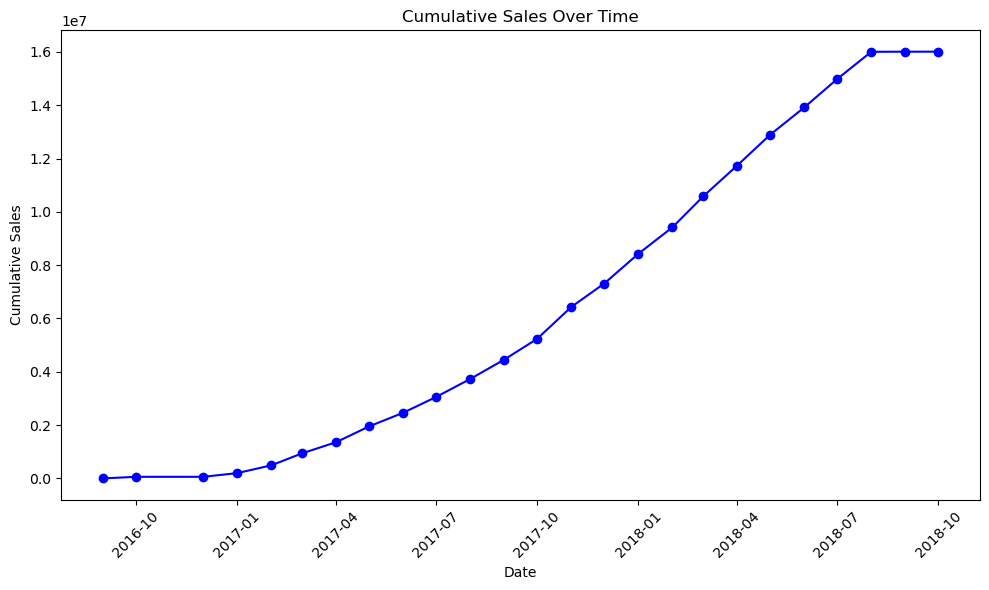

In [35]:
query = """
SELECT years, months, payment, 
       SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT YEAR(orders.order_purchase_timestamp) AS years,
           MONTH(orders.order_purchase_timestamp) AS months,
           ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a
"""

# Execute query and fetch data
cur.execute(query)
data = cur.fetchall()

# Create DataFrame with specified column names
df = pd.DataFrame(data, columns=['Year', 'Month', 'Payment', 'Cumulative Sales'])

# Print DataFrame
print(df)

# Create a 'Date' column for plotting
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

# Plot cumulative sales over time
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Cumulative Sales'], marker='o', color='b')
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 13. Calculate the year-over-year growth rate of total sales.

In [41]:
query = """ 

WITH yearly_sales AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)
SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) / LAG(payment, 1) OVER (ORDER BY years)) * 100 AS YoY_growth
FROM yearly_sales;

"""

# Execute query and fetch data
cur.execute(query)
data = cur.fetchall()

# Create DataFrame with specified column names
df = pd.DataFrame(data, columns = ["years", "YoY % growth"])

# Print DataFrame
print(df)

   years  YoY % growth
0   2016           NaN
1   2017  12112.703761
2   2018     20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [43]:
query = """
WITH first_purchase AS (
    SELECT customers.customer_id,
           MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
repeat_purchase AS (
    SELECT first_purchase.customer_id
    FROM first_purchase
    JOIN orders ON orders.customer_id = first_purchase.customer_id
    AND orders.order_purchase_timestamp > first_order
    AND orders.order_purchase_timestamp < DATE_ADD(first_order, INTERVAL 6 MONTH)
    GROUP BY first_purchase.customer_id
)

SELECT 
    100 * COALESCE(COUNT(DISTINCT repeat_purchase.customer_id) / COUNT(DISTINCT first_purchase.customer_id), 0) 
    AS retention_rate
FROM first_purchase
LEFT JOIN repeat_purchase ON first_purchase.customer_id = repeat_purchase.customer_id;
"""

# Execute query and fetch data
cur.execute(query)
data = cur.fetchall()

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print DataFrame
print(df) 

# Since none of our customers made another purchase within 6 months of their first purchase, the retention rate is 0.

        0
0  0.0000


# 15. Identify the top 3 customers who spent the most money in each year.

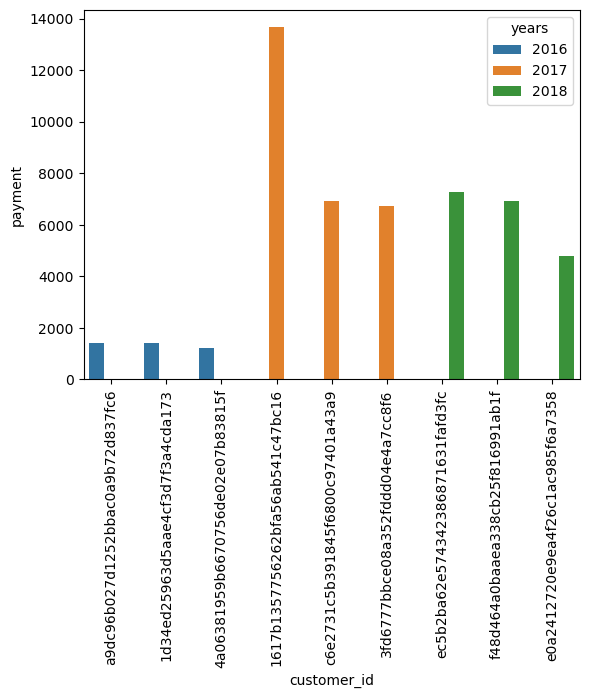

In [44]:
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER(PARTITION BY YEAR(orders.order_purchase_timestamp) 
                          ORDER BY SUM(payments.payment_value) DESC) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY YEAR(orders.order_purchase_timestamp), orders.customer_id
) AS a
WHERE d_rank <= 3;
"""

# Execute query and fetch data
cur.execute(query)
data = cur.fetchall()

# Create DataFrame with specified column names
df = pd.DataFrame(data, columns=['years', 'customer_id', 'payment', 'rank'])

# Plotting the data
sns.barplot(x="customer_id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.show()

In [46]:
# Close the database connection.
cur.close()
db.close()